In [1]:
from gurobipy import *

## 本研究

In [108]:
def IPS6(ship_num,stack_num,height,n,size,beta):
 

  O1=[i+1 for i in range(ship_num)]

  S=[i+1 for i in range(stack_num)]
  H=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]


  f=stack_num*height-sum(n)

  from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
  import random
  from random import seed
  import numpy as np
  from scipy.stats import multivariate_normal

  np.random.seed(1)

  # 期待値と分散共分散行列の準備
  mean = np.arange(1,ship_num+1)
  cov=np.zeros((ship_num,ship_num))
  for i in range(ship_num):
    for j in range(ship_num):
      if i==j:
        cov[i][i]=4*np.random.randn()
      elif i>j:
        cov[i][j]=np.random.randn()
        cov[j][i]=cov[i][j]

  # numpy を用いた生成
  size=size
  data_1 = np.random.multivariate_normal(mean, cov, size=size)

  # print(data_1.shape)

  # print(np.mean(data_1, axis=0))

  # print(np.cov(data_1, rowvar=False))

  # print(data_1)
  O_=np.argsort(data_1)
  O_=O_+np.ones((size,ship_num)).astype(int)
  O=O_.tolist()

  # data_2 = multivariate_normal(mean, cov).rvs(size=200)

  # print(data_2.shape)

  # print(np.mean(data_2, axis=0))

  # print(np.cov(data_2, rowvar=False))

  a=[]
  b={}
  for i in O:
    # print(i)
    if not i in a:
      a.append(i)
      for j in a:
        b[tuple(j)]=O.count(j)

  m=Model("IPS6")

  alpha=m.addVar(vtype="C")

  # 変数の定義
  x,c,d={},{},{}
  for s in S:
    for h in H:
      for p in P:
        x[s,h,p]=m.addVar(vtype="B")

  for s in S:
    for h in range(2,len(H)+1):
      for i,o in enumerate(O):
        c[s,h,i]=m.addVar(vtype="c",lb=0)

  for i in range(len(O)):
    d[i]=m.addVar(vtype="C",lb=0)

  for p in P:
    m.addConstr(quicksum(x[s,h,p] for s in S for h in H)==n[p-1])

  for s in S:
    for h in H:
      m.addConstr(quicksum(x[s,h,p] for p in P)<=1)

  for s in S:
    for h in range(1,len(H)):
      m.addConstr(quicksum(x[s,h+1,p] for p in P)<=quicksum(x[s,h,p] for p in P))

  for s in S:
    for h in range(2,len(H)+1):
      for h_ in range(1,h):
        for i,o in enumerate(O):
          for j,p in enumerate(o):
            m.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

  for i in range(len(O)):
    m.addConstr(d[i]>=quicksum(c[s,h,i] for s in S for h in H if h!=1)-alpha)


  m.setObjective(alpha+quicksum(d[i] for i in range(len(O)))/((1-beta)*len(O)))

  if f>=height:
    m.optimize()
  else:
    print("f<h")

  print("================================================")

# def result(self):
  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:
  # for (s,h,p,t) in x:
  #   if t==len(T):
  #     if x[s,h,p,t].X>EPS:
  #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

    for (s,h,i) in c:
      if c[s,h,i].X>EPS:
        print("c[%2s,%2s,%2s]=%3s  %4s" %(s,h,i,c[s,h,i].X,O[i]))

    global result
    result=np.zeros((height,stack_num))
    for (s,h,p) in x:
      if x[s,h,p].X>EPS:
    # print("x[%2s,%2s,%2s]=%3s  %4s" %(s,h,p,x[s,h,p].X,O[i]))
        result[height-h][s-1]=int(p)

    result=result.astype(int)
    print("VaR=",alpha.X)
    print("the objective function", m.objVal)
    print(result)


    data_2 = np.random.multivariate_normal(mean, cov, size=size)

    OR_=np.argsort(data_2)
    OR_=OR_+np.ones((size,ship_num)).astype(int)
    OR=OR_.tolist()


    penalty=[]
    for k in OR:
      O=k
      a=0
      for j in range(stack_num):
          for i in range(1,height):
              for i_ in range(i+1,height+1):
                  if not result[i-1][j]==0 or result[i_-1][j]==0:
                      if O[result[i-1][j]-1]>O[result[i_-1][j]-1]:
                          a+=1
                          # print("penalty!")
                              # print(i,i_,j+1,O)
                          break
      penalty.append(a)
      # print(a)
    penalty=np.array(penalty)

    import matplotlib.pyplot as plt
    plt.boxplot(penalty)

C:\Users\Owner\AppData\Local\Temp\ipykernel_9268\2472933820.py:34: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = np.random.multivariate_normal(mean, cov, size=size)


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 72166 rows, 2861 columns and 1011896 nonzeros
Model fingerprint: 0x7875383d
Variable types: 2501 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 108 rows and 0 columns
Presolve time: 1.74s
Presolved: 72058 rows, 2861 columns, 1011500 nonzeros
Variable types: 2501 continuous, 360 integer (360 binary)
Found heuristic solution: objective 15.0000000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 648 iterations, 0.57 seconds (0.83 work units)
Total elapsed time = 5.58s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node 

C:\Users\Owner\AppData\Local\Temp\ipykernel_9268\2472933820.py:140: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


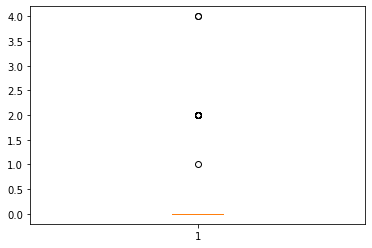

In [109]:
ship_num=12
stack_num=6
height=5
n=[3,2,2,2,1,2,2,2,1,3,2,2]
IPS6(ship_num,stack_num,height,n,100,0.8)

## 先行研究１

In [102]:
def robust(ship_num,stack_num,height,n,Gamma,size):
    # nと初期配置を変更しなければいけない
    num=sum(n)

    import numpy as np

    O1=[i+1 for i in range(ship_num)]

    Q=[i+1 for i in range(stack_num)]
    L=[i+1 for i in range(height)]
    P=[i+1 for i in range(ship_num)]
    I=[i+1 for i in range(num)]
    f=stack_num*height-len(I)
    a=1
    gamma=[]
    for i in n:
        for j in range(1,i+1):
            gamma.append(a)
        a+=1
    
    m=Model("BI")

    # 変数の定義
    alpha,beta={},{}
    for i in I:
        for q in Q:
            alpha[i,q]=m.addVar(vtype="B")
            beta[i,q]=m.addVar(vtype="B")
    J=[]
    for i in I:
        J.append([])
        for j in I:
            if gamma[i-1]<gamma[j-1]:
                if gamma[j-1]-gamma[i-1]<=Gamma:
                    J[i-1].append(j)

    for q in Q:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for i in I)<=len(L))

    for i in I:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for q in Q)==1)

    for i in I:
        for j in J[i-1]:
            for q in Q:
                m.addConstr(alpha[i,q]+alpha[j,q]+beta[j,q]<=1)

    m.setObjective(quicksum(beta[i,q] for i in I for q in Q))

    if f>=height:
        m.optimize()

    EPS=1.e-6

    if m.Status == GRB.OPTIMAL:
        print("====================================================")
        # for (s,h,p,t) in x:
        #   if t==len(T):
        #     if x[s,h,p,t].X>EPS:
        #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

        for (i,q) in beta:
            if beta[i,q].X>EPS:
                print("beta[%2s,%2s]=%3s" %(gamma[i-1],q,beta[i,q].X))

        EPS=1.e-6
        a=[]
        for q in Q:
            a.append([])
        for (i,q) in alpha:
            if alpha[i,q].X>EPS:
                a[q-1].append(gamma[i-1])
        
        for (i,q) in beta:
            if beta[i,q].X>EPS:
                a[q-1].append(gamma[i-1])

        for q in Q:
            a[q-1]=sorted(a[q-1],reverse=True)

        global result_r
        result_r=np.zeros((height,stack_num))
        for q in Q:
            for i,r in enumerate(a[q-1]):
                result_r[height-i-1][q-1]=r
            # print(i,r)

        result_r=result_r.astype(int)
        
        print(result_r)
        print("the objective function", m.objVal)

        from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
        import random
        from random import seed
        import numpy as np
        from scipy.stats import multivariate_normal

        np.random.seed(1)

        # 期待値と分散共分散行列の準備
        mean = np.arange(1,ship_num+1)
        cov=np.zeros((ship_num,ship_num))
        for i in range(ship_num):
            for j in range(ship_num):
                if i==j:
                    cov[i][i]=4*np.random.randn()
                elif i>j:
                    cov[i][j]=np.random.randn()
                    cov[j][i]=cov[i][j]

        # numpy を用いた生成
        size=size

        data_2 = np.random.multivariate_normal(mean, cov, size=size)

        OR_=np.argsort(data_2)
        OR_=OR_+np.ones((size,ship_num)).astype(int)
        OR=OR_.tolist()


        penalty_r=[]
        for k in OR:
            O=k
            a=0
            for j in range(stack_num):
                for i in range(1,height):
                    for i_ in range(i+1,height+1):
                        if not result_r[i-1][j]==0 or result_r[i_-1][j]==0:
                            if O[result_r[i-1][j]-1]>O[result_r[i_-1][j]-1]:
                                a+=1
                                # print("penalty!")
                                # print(i,i_,j+1,O)
                                break
            penalty_r.append(a)
            # print(a)
        penalty_r=np.array(penalty_r)
        print(penalty_r)

        import matplotlib.pyplot as plt
        plt.boxplot(penalty_r)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 276 rows, 288 columns and 1314 nonzeros
Model fingerprint: 0x3290316e
Variable types: 0 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 0 rows and 12 columns
Presolve time: 0.00s
Presolved: 276 rows, 276 columns, 1266 nonzeros
Variable types: 0 continuous, 276 integer (276 binary)
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 0 13 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[ 1  0  1  0  0  0]
 [ 3  1  5 

C:\Users\Owner\AppData\Local\Temp\ipykernel_9268\1933213885.py:115: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


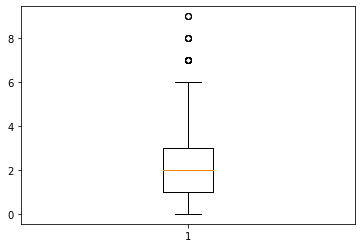

In [103]:
ship_num=12
stack_num=6
height=6

robust(ship_num,stack_num,height,n,1,1000)
# AI.solve()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 504 rows, 288 columns and 1998 nonzeros
Model fingerprint: 0x4cb3d62b
Variable types: 0 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 14.0000000
Presolve removed 150 rows and 12 columns
Presolve time: 0.00s
Presolved: 354 rows, 276 columns, 1776 nonzeros
Variable types: 0 continuous, 276 integer (276 binary)
Found heuristic solution: objective 3.0000000

Root relaxation: objective 0.000000e+00, 75 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%

C:\Users\Owner\AppData\Local\Temp\ipykernel_9268\1933213885.py:115: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


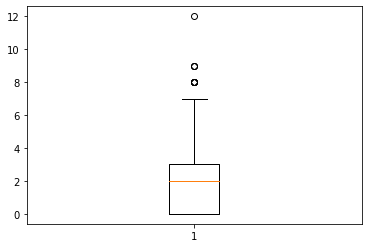

In [104]:
ship_num=12
stack_num=6
height=6

robust(ship_num,stack_num,height,n,2,1000)
# AI.solve()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 696 rows, 288 columns and 2574 nonzeros
Model fingerprint: 0xee0a42ab
Variable types: 0 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 270 rows and 12 columns
Presolve time: 0.00s
Presolved: 426 rows, 276 columns, 2364 nonzeros
Variable types: 0 continuous, 276 integer (276 binary)
Found heuristic solution: objective 2.0000000

Root relaxation: objective 0.000000e+00, 71 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%

C:\Users\Owner\AppData\Local\Temp\ipykernel_9268\1933213885.py:115: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


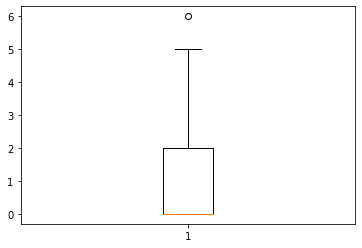

In [105]:
ship_num=12
stack_num=6
height=6

robust(ship_num,stack_num,height,n,3,1000)
# AI.solve()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 876 rows, 288 columns and 3114 nonzeros
Model fingerprint: 0x77d3c335
Variable types: 0 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 12.0000000
Presolve removed 306 rows and 12 columns
Presolve time: 0.01s
Presolved: 570 rows, 276 columns, 3468 nonzeros
Variable types: 0 continuous, 276 integer (276 binary)
Found heuristic solution: objective 9.0000000

Root relaxation: objective 0.000000e+00, 111 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00

C:\Users\Owner\AppData\Local\Temp\ipykernel_9268\1933213885.py:115: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


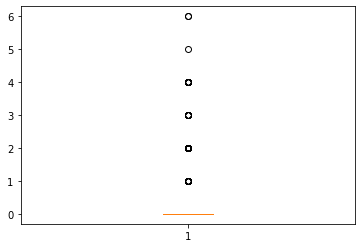

In [106]:
ship_num=12
stack_num=6
height=6

robust(ship_num,stack_num,height,n,4,1000)
# AI.solve()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1038 rows, 288 columns and 3600 nonzeros
Model fingerprint: 0x6c711203
Variable types: 0 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 390 rows and 12 columns
Presolve time: 0.01s
Presolved: 648 rows, 276 columns, 4362 nonzeros
Variable types: 0 continuous, 276 integer (276 binary)
Found heuristic solution: objective 7.0000000

Root relaxation: objective 0.000000e+00, 206 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.0

C:\Users\Owner\AppData\Local\Temp\ipykernel_9268\1933213885.py:115: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


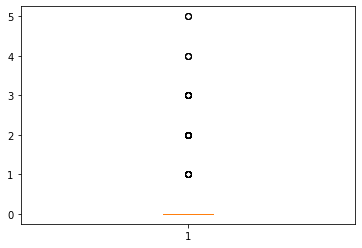

In [107]:
ship_num=12
stack_num=6
height=6

robust(ship_num,stack_num,height,n,5,1000)
# AI.solve()

## BRP

In [58]:
# nと初期配置を変更しなければいけない
ship_num=3
stack_num=4
height=4
num=8

O1=[i+1 for i in range(ship_num)]

Q=[i+1 for i in range(stack_num)]
L=[i+1 for i in range(height)]
P=[i+1 for i in range(ship_num)]
# I=[i+1 for i in range(num)]
I=[1,2,3,4,5,6,7,8]
f=stack_num*height-len(I)
time = 3*len(I)
T=[i+1 for i in range(time)]

In [59]:
m=Model("BRP")

# 変数の定義
b,v,x,y={},{},{},{}
for i in Q:
  for j in L:
    for n in I:
      for t in T:
        b[i,j,n,t]=m.addVar(vtype="B")
        y[i,j,n,t]=m.addVar(vtype="B")

for n in I:
  for t in T:
    v[n,t]=m.addVar(vtype="B")

for i in Q:
  for j in L:
    for k in Q:
      for l in L:
        for n in I:
          for t in T:
            x[i,j,k,l,n,t]=m.addVar(vtype="B")

for n in I:
  for t in T:
    m.addConstr(quicksum(b[i,j,n,t] for i in Q for j in L)+v[n,t]==1)

for i in Q:
  for j in L:
    for t in T:
      m.addConstr(quicksum(b[i,j,n,t] for n in I)<=1)

for i in Q:
  for j in range(1,len(L)):
    for t in T:
      m.addConstr(quicksum(b[i,j,n,t] for n in I)>=quicksum(b[i,j+1,n,t] for n in I))

for t in T:
  m.addConstr(quicksum(x[i,j,k,l,n,t] for i in Q for j in L for k in Q for l in L for n in I)+quicksum(y[i,j,n,t] for i in Q for j in L for n in I)<=1)

for n in range(1,len(I)):
  m.addConstr(quicksum(v[n,t] for t in T)>=quicksum(v[n+1,t] for t in T)+1)

for i in Q:
  for j in L:
    for n in I:
      for t in range(2,len(T)+1):
        m.addConstr(b[i,j,n,t]==b[i,j,n,t-1]+quicksum(x[k,l,i,j,n,t-1] for k in Q for l in L)-quicksum(x[i,j,k,l,n,t-1] for k in Q for l in L)-y[i,j,n,t-1])

for n in I:
  for t in T:
    m.addConstr(v[n,t]==quicksum(y[i,j,n,t_] for i in Q for j in L for t_ in range(1,t)))

m.setObjective(quicksum(v[len(I),t] for t in T),GRB.MAXIMIZE)

In [60]:
m.addConstr(b[1,1,8,1]==1)
m.addConstr(b[1,2,7,1]==1)
m.addConstr(b[1,3,6,1]==1)
m.addConstr(b[2,1,2,1]==1)
m.addConstr(b[3,1,1,1]==1)
m.addConstr(b[3,2,3,1]==1)
m.addConstr(b[3,3,4,1]==1)
m.addConstr(b[3,4,5,1]==1)

<gurobi.Constr *Awaiting Model Update*>

In [61]:
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 4039 rows, 55488 columns and 196184 nonzeros
Model fingerprint: 0x043e4b75
Variable types: 0 continuous, 55488 integer (55488 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 210 rows and 8938 columns (presolve time = 6s) ...
Presolve removed 268 rows and 10257 columns (presolve time = 10s) ...
Presolve removed 293 rows and 11370 columns
Presolve time: 10.59s
Presolved: 3746 rows, 44118 columns, 139682 nonzeros
Variable types: 0 continuous, 44118 integer (44118 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2000000e+01   1.690000e+02   0.000000e+00     11s
    3134    1.4455150e+01   0.000000e+00   0.000000e+00     12s

Root relaxation: obj

In [62]:
print("the objective function", len(T)-m.objVal)
#   print("VaR=",alpha.X)

the objective function 11.0


In [63]:
EPS=1.e-5
for (n,t) in v:
  if t!=1:
    if (v[n,t].X-v[n,t-1].X)>EPS:
      print("v[%2s,%2s]=%3s" %(n,t,v[n,t].X))

v[ 1, 5]=1.0
v[ 2, 6]=1.0
v[ 3, 7]=1.0
v[ 4, 8]=1.0
v[ 5, 9]=1.0
v[ 6,10]=1.0
v[ 7,11]=1.0
v[ 8,12]=1.0
